In [1]:
import pennylane as qml
from pennylane import numpy as np

num_wires = 4
num_layers = 5

device = qml.device("qiskit.aer", wires=num_wires, shots=1000)

ansatz = qml.StronglyEntanglingLayers

all_pauliz_tensor_prod = qml.prod(*[qml.PauliZ(i) for i in range(num_wires)])


def circuit(param):
    ansatz(param, wires=list(range(num_wires)))
    return qml.expval(all_pauliz_tensor_prod)


cost_function = qml.QNode(circuit, device)

np.random.seed(50)

param_shape = ansatz.shape(num_layers, num_wires)
init_param = np.random.normal(scale=0.1, size=param_shape, requires_grad=True)

In [2]:
def run_optimizer(opt, cost_function, init_param, num_steps, interval, execs_per_step):
    # Copy the initial parameters to make sure they are never overwritten
    param = init_param.copy()

    # Obtain the device used in the cost function
    dev = cost_function.device

    # Initialize the memory for cost values during the optimization
    cost_history = []
    # Monitor the initial cost value
    cost_history.append(cost_function(param))
    exec_history = [0]

    print(f"\nRunning the {opt.__class__.__name__} optimizer for {num_steps} iterations.")
    for step in range(num_steps):
        # Print out the status of the optimization
        if step % interval == 0:
            print(
                f"Step {step:3d}: Circuit executions: {exec_history[step]:4d}, "
                f"Cost = {cost_history[step]}"
            )

        # Perform an update step
        param = opt.step(cost_function, param)

        # Monitor the cost value
        cost_history.append(cost_function(param))
        exec_history.append((step + 1) * execs_per_step)

    print(
        f"Step {num_steps:3d}: Circuit executions: {exec_history[-1]:4d}, "
        f"Cost = {cost_history[-1]}"
    )
    return cost_history, exec_history

In [3]:
num_steps_spsa = 200
opt = qml.SPSAOptimizer(maxiter=num_steps_spsa, c=0.15, a=0.2)
# We spend 2 circuit evaluations per step:
execs_per_step = 2
cost_history_spsa, exec_history_spsa = run_optimizer(
    opt, cost_function, init_param, num_steps_spsa, 20, execs_per_step
)


Running the SPSAOptimizer optimizer for 200 iterations.
Step   0: Circuit executions:    0, Cost = 0.9
Step  20: Circuit executions:   40, Cost = 0.226
Step  40: Circuit executions:   80, Cost = -0.724
Step  60: Circuit executions:  120, Cost = -0.906
Step  80: Circuit executions:  160, Cost = -0.934
Step 100: Circuit executions:  200, Cost = -0.978
Step 120: Circuit executions:  240, Cost = -0.982
Step 140: Circuit executions:  280, Cost = -0.992
Step 160: Circuit executions:  320, Cost = -0.994
Step 180: Circuit executions:  360, Cost = -0.998
Step 200: Circuit executions:  400, Cost = -0.992


In [4]:
num_steps_grad = 15
opt = qml.GradientDescentOptimizer(stepsize=0.3)
# We spend 2 circuit evaluations per parameter per step:
execs_per_step = 2 * np.prod(param_shape)
cost_history_grad, exec_history_grad = run_optimizer(
    opt, cost_function, init_param, num_steps_grad, 3, execs_per_step
)


Running the GradientDescentOptimizer optimizer for 15 iterations.
Step   0: Circuit executions:    0, Cost = 0.918
Step   3: Circuit executions:  360, Cost = -0.388
Step   6: Circuit executions:  720, Cost = -0.98
Step   9: Circuit executions: 1080, Cost = -0.994
Step  12: Circuit executions: 1440, Cost = -1.0
Step  15: Circuit executions: 1800, Cost = -1.0


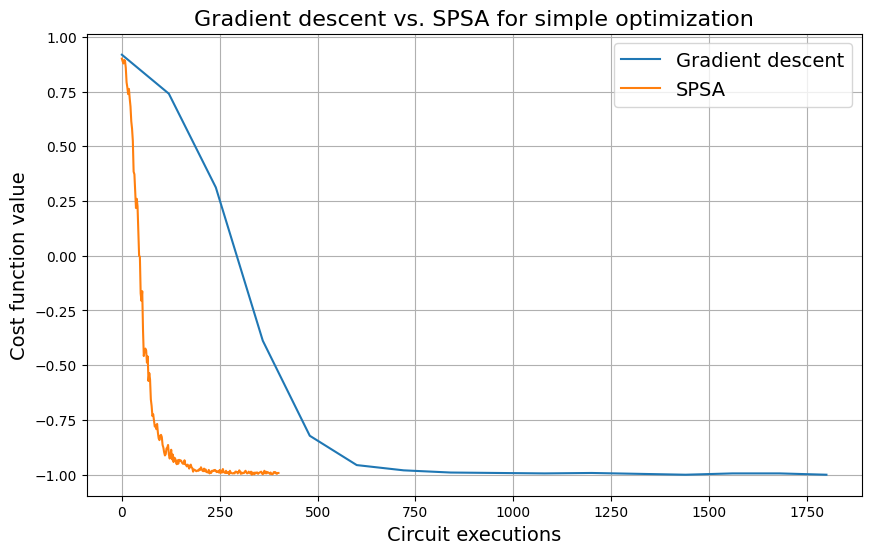

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(exec_history_grad, cost_history_grad, label="Gradient descent")
plt.plot(exec_history_spsa, cost_history_spsa, label="SPSA")

plt.xlabel("Circuit executions", fontsize=14)
plt.ylabel("Cost function value", fontsize=14)
plt.grid()

plt.title("Gradient descent vs. SPSA for simple optimization", fontsize=16)
plt.legend(fontsize=14)
plt.show()

In [6]:
grad_execs_to_prec = exec_history_grad[np.where(np.array(cost_history_grad) < -0.99)[0][0]]
spsa_execs_to_prec = exec_history_spsa[np.where(np.array(cost_history_spsa) < -0.99)[0][0]]
print(f"Circuit execution ratio: {np.round(grad_execs_to_prec/spsa_execs_to_prec, 3)}.")

Circuit execution ratio: 4.286.


### SPSA and the Variational Quantum Eigensolver

In [7]:
from pennylane import qchem

symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])
h2_ham, num_qubits = qchem.molecular_hamiltonian(symbols, coordinates)
h2_ham = qml.Hamiltonian(qml.math.real(h2_ham.coeffs), h2_ham.ops)

true_energy = -1.136189454088


# Variational ansatz for H_2 - see Intro VQE demo for more details
def ansatz(param, wires):
    qml.BasisState(np.array([1, 1, 0, 0]), wires=wires)
    for i in wires:
        qml.Rot(*param[0, i], wires=i)
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[2, 0])
    qml.CNOT(wires=[3, 1])
    for i in wires:
        qml.Rot(*param[1, i], wires=i)

In [8]:
from qiskit.providers.aer import noise
from qiskit.providers.fake_provider import FakeLima

# Load a fake backed to create a noise model, and create a device using that model
noise_model = noise.NoiseModel.from_backend(FakeLima())
noisy_device = qml.device(
    "qiskit.aer", wires=num_qubits, shots=1000, noise_model=noise_model
)


def circuit(param):
    ansatz(param, range(num_qubits))
    return qml.expval(h2_ham)


cost_function = qml.QNode(circuit, noisy_device)

# This random seed was used in the original VQE demo and is known to allow the
# gradient descent algorithm to converge to the global minimum.
np.random.seed(0)
param_shape = (2, num_qubits, 3)
init_param = np.random.normal(0, np.pi, param_shape, requires_grad=True)

# Initialize the optimizer - optimal step size was found through a grid search
opt = qml.GradientDescentOptimizer(stepsize=2.2)

# We spend 2 * 15 circuit evaluations per parameter per step, as there are
# 15 Hamiltonian terms
execs_per_step = 2 * 15 * np.prod(param_shape)
# Run the optimization
cost_history_grad, exec_history_grad = run_optimizer(
    opt, cost_function, init_param, num_steps_grad, 3, execs_per_step
)

final_energy = cost_history_grad[-1]
print(f"\nFinal estimated value of the ground state energy = {final_energy:.8f} Ha")
print(
    f"Distance to the true ground state energy: {np.abs(final_energy - true_energy):.8f} Ha"
)


Running the GradientDescentOptimizer optimizer for 15 iterations.
Step   0: Circuit executions:    0, Cost = 0.35510785403700296
Step   3: Circuit executions: 2160, Cost = -0.46630019692003155
Step   6: Circuit executions: 4320, Cost = -0.9379696058260201
Step   9: Circuit executions: 6480, Cost = -1.0388260543824441
Step  12: Circuit executions: 8640, Cost = -1.0416532229394015
Step  15: Circuit executions: 10800, Cost = -1.0412387007834816

Final estimated value of the ground state energy = -1.04123870 Ha
Distance to the true ground state energy: 0.09495075 Ha


In [9]:
num_steps_spsa = 160
opt = qml.SPSAOptimizer(maxiter=num_steps_spsa, c=0.3, a=1.5)

# We spend 2 * 15 circuit evaluations per step, as there are 15 Hamiltonian terms
execs_per_step = 2 * 15
# Run the optimization
cost_history_spsa, exec_history_spsa = run_optimizer(
    opt, cost_function, init_param, num_steps_spsa, 20, execs_per_step
)
final_energy = cost_history_spsa[-1]

print(f"\nFinal estimated value of the ground state energy = {final_energy:.8f} Ha")
print(
    f"Distance to the true ground state energy: {np.abs(final_energy - true_energy):.8f} Ha"
)


Running the SPSAOptimizer optimizer for 160 iterations.
Step   0: Circuit executions:    0, Cost = 0.3687016089847102
Step  20: Circuit executions:  600, Cost = -0.1379961892799049
Step  40: Circuit executions: 1200, Cost = -0.5245819787742059
Step  60: Circuit executions: 1800, Cost = -0.837021029118628
Step  80: Circuit executions: 2400, Cost = -1.0136491775164491
Step 100: Circuit executions: 3000, Cost = -1.0395705698125235
Step 120: Circuit executions: 3600, Cost = -1.0490018162638066
Step 140: Circuit executions: 4200, Cost = -1.0412625378644134
Step 160: Circuit executions: 4800, Cost = -1.0459762457511688

Final estimated value of the ground state energy = -1.04597625 Ha
Distance to the true ground state energy: 0.09021321 Ha


In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(exec_history_grad, cost_history_grad, label="Gradient descent")
plt.plot(exec_history_spsa, cost_history_spsa, label="SPSA")
plt.axhline(y=true_energy, color="black", linestyle="--", label="True energy")

plt.title("$H_2$ energy from VQE using gradient descent vs. SPSA", fontsize=16)
plt.xlabel("Circuit executions", fontsize=14)
plt.ylabel("Energy (Ha)", fontsize=14)
plt.grid()

plt.legend(fontsize=14)
plt.show()